	1.	Setup & project paths
	2.	Load config, device, encoder checkpoint
	3.	Load encoded families (.pt)
	4.	Embed all sequences → Z (NxD), labels Y, names NAMES
	5.	Quick PCA sanity plot
	6.	UMAP scatter (nice non-linear view)
	7.	Cluster metrics (silhouette, Davies–Bouldin)
	8.	Prototype–prototype distance heatmap
	9.	Nearest-neighbor sanity (which families look similar)
	10.	Save a mini results README

In [2]:
#Setup & paths 
import os, sys
from pathlib import Path

#if running from notbeooks/, jump to project root for imports
ROOT = Path(os.getcwd()).resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent
#Make sure project root is importable
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print("Project root: ", ROOT)
os.makedirs(ROOT / "results", exist_ok=True)

Project root:  /Users/mderaznasr/Documents/GitHub/Protein-fewshot


In [3]:
# CELL — Config, device, load encoder checkpoint (robust)
import os, sys, re, torch
from pathlib import Path
from models.encoder import ProteinEncoderCNN

# Load CONF (try both locations)
try:
    from data.configs.protonet import CONF as cfg
except Exception:
    from data.configs.protonet import CONF as cfg  # fallback if you moved configs

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# Find a checkpoint
ROOT = Path(os.getcwd()).resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

ckpt_dir = ROOT / "checkpoints"
candidates = [ckpt_dir / "best_protonet.pt", ckpt_dir / "best_model.pt"]
ckpt_path = next((c for c in candidates if c.exists()), None)

if ckpt_path is None:
    pts = list(ROOT.rglob("*.pt"))
    if not pts:
        raise FileNotFoundError("No checkpoint found anywhere (.pt). Train first.")
    ckpt_path = pts[0]

print("Using checkpoint:", ckpt_path.relative_to(ROOT))

# Build the encoder with same proj_dim as training
proj_dim = int(cfg.get("proj_dim", 128))
model = ProteinEncoderCNN(proj_dim=proj_dim).to(device).eval()

# ---- Robust loader: unwrap & strip prefixes so keys match encoder ----
sd = torch.load(ckpt_path, map_location=device)

# 1) Unwrap if saved as {"state_dict": ..., "config": ...}
if isinstance(sd, dict) and "state_dict" in sd:
    sd = sd["state_dict"]

# 2) Strip common prefixes added by trainers or DataParallel
def strip_prefix(d, pattern):
    out = {}
    for k, v in d.items():
        out[re.sub(pattern, "", k)] = v
    return out

keys = list(sd.keys())

# Remove DataParallel "module." if present
if any(k.startswith("module.") for k in keys):
    sd = strip_prefix(sd, r"^module\.")
    keys = list(sd.keys())

# If the full ProtoNet was saved, weights may live under "encoder."
if any(k.startswith("encoder.") for k in keys):
    sd = strip_prefix(sd, r"^encoder\.")
    keys = list(sd.keys())

# (Optional) Handle other possible wrappers
for prefix in ("model.", "net.", "backbone.", "protonet."):
    if any(k.startswith(prefix) for k in keys):
        sd = strip_prefix(sd, rf"^{re.escape(prefix)}")
        keys = list(sd.keys())

# 3) Try strict=True first; if it fails, relax to strict=False
try:
    model.load_state_dict(sd, strict=True)
    print("✓ Loaded with strict=True")
except Exception as e:
    print("Strict load failed → retrying strict=False\nReason:", e)
    incompat = model.load_state_dict(sd, strict=False)
    if incompat.missing_keys:
        print("  Missing keys:", incompat.missing_keys)
    if incompat.unexpected_keys:
        print("  Unexpected keys:", incompat.unexpected_keys)
    print("✓ Loaded with strict=False")

# 4) Tiny sanity forward to confirm shapes
with torch.no_grad():
    x_test = torch.randint(0, 21, (4, int(cfg.get("max_len", 400))), device=device)
    z_test = model(x_test)
    print(f"Sanity: x={tuple(x_test.shape)} -> z={tuple(z_test.shape)} | ||z|| mean={z_test.norm(dim=-1).mean().item():.3f}")

print(f"Encoder ready (proj_dim={proj_dim}).")

Device: mps
Using checkpoint: checkpoints/best_protonet.pt
✓ Loaded with strict=True
Sanity: x=(4, 400) -> z=(4, 128) | ||z|| mean=1.000
Encoder ready (proj_dim=128).


In [4]:
# Load encoded families from data/encoded/*.pt
import torch
from typing import Dict

ENC_DIR = ROOT / cfg.get("encoded_dir", "data/encoded")
print("Encoded dir:", ENC_DIR)
assert ENC_DIR.exists(), f"Missing: {ENC_DIR}"

def load_family_pt(path: Path) -> torch.LongTensor:
    """ Return LongTensor[num_seq, max_len] of token IDs (0-PAD)"""
    obj = torch.load(path, map_location="cpu")
    if isinstance(obj, torch.Tensor):
        return obj.long()
    if isinstance(obj, list):
        return torch.stack(obj).long()
    if isinstance(obj, dict):
        if "X" in obj and isinstance(obj["X"], torch.Tensor):
            return obj["X"].long()
        if "tensors" in obj and isinstance(obj["tensors"], list):
            return torch.stack(obj["tensors"]).long()
    raise ValueError(f"Unsupported .pt format: {path.name}")

families: Dict[str, torch.Tensor] = {}
for p in sorted(ENC_DIR.glob("*.pt")):
    try:
        X = load_family_pt(p)
        if X.ndim != 2 or X.shape[0] < 1:
            print(f"Skip {p.name}: shape {tuple(X.shape)}")
            continue
        families[p.stem] = X
    except Exception as e:
        print(f"Skip {p.name} → {e}")

print(f"Loaded families: {len(families)}")
for k in list(families.keys())[:10]:
    print(f"  {k:<28} n={families[k].shape[0]} L={families[k].shape[1]}")

Encoded dir: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/data/encoded
Loaded families: 21
  Antenna                      n=47 L=400
  C2Domain                     n=100 L=400
  Fibronectin                  n=28 L=400
  Granulin                     n=17 L=400
  Guanine                      n=28 L=400
  Kringle                      n=96 L=400
  Melatonin                    n=25 L=400
  Metallothionein              n=100 L=400
  OuterMembraneUsher           n=39 L=400
  PPE                          n=97 L=400


In [5]:
# Embed all sequences into Z (N_total x D), with label vector Y and name map 
'''
This cell takes every protein sequence from every family, runs them through your encoder model, and turns them into vectors (embeddings).
Then it creates matching label arrays so each embedding knows which family it came from.
Finally, it combines everything into big arrays (Z, Y, and NAMES) that can be used later for visualization, clustering, or few-shot learning experiments.
'''
import numpy as np
import torch

@torch.no_grad()
def embed_all_families(model, fam_dict, device):
    Zs, Ys, Ns = [],[],[]
    name_to_id = {}
    for i, name in enumerate(sorted(fam_dict.keys())):
        name_to_id[name] = i
    for name in sorted(fam_dict.keys()):
        X = fam_dict[name]
        x = X.to(device)
        z = model(x).cpu()
        Zs.append(z)
        Ys.append(torch.full((z.shape[0], ), name_to_id[name], dtype=torch.long))
        Ns.extend([name]*z.shape[0])
    Z = torch.cat(Zs, dim=0).numpy()
    Y = torch.cat(Ys, dim=0).numpy()
    return Z, Y, Ns, name_to_id
Z, Y, NAMES, name_to_id = embed_all_families(model, families, device)
print("Z:", Z.shape, "Y:", Y.shape, "examples:", len(NAMES))

Z: (1208, 128) Y: (1208,) examples: 1208


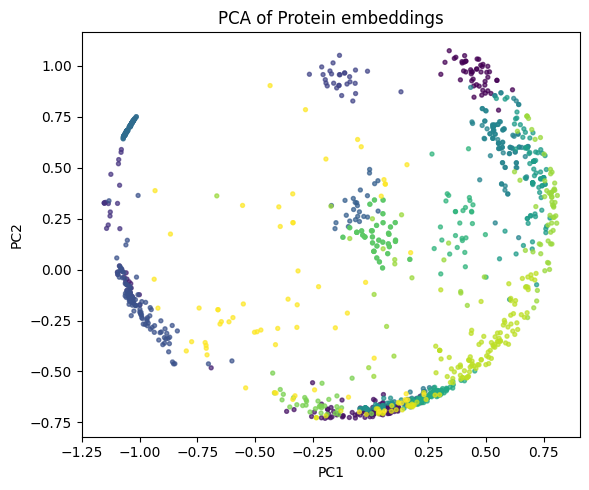

Saved: results/pca_embeddings.png | Var explained: [0.411 0.358]


In [6]:
# PCA (fast linear projection) for a first look
'''
This cell compresses all your high-dimensional protein embeddings down to just two numbers 
per sequence (using PCA) so you can see them on a 2D scatterplot.
Each point is a protein, each color is a family, and if the embeddings are good, 
points from the same family will cluster together.
Finally, it saves the plot image and tells you how much information those 
two dimensions captured.
'''

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
Zp = pca.fit_transform(Z)

plt.figure(figsize=(6,5))
sc = plt.scatter(Zp[:,0], Zp[:,1], c=Y, s=8, alpha=0.7)
plt.title("PCA of Protein embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(ROOT / "results/pca_embeddings.png", dpi=160)
plt.show()
print("Saved: results/pca_embeddings.png | Var explained:", pca.explained_variance_ratio_.round(3))
# Why: PCA is quick to confirm there’s some separation before moving to UMAP/t-SNE.

/Users/mderaznasr/Documents/GitHub/Protein-fewshot/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mderaznasr/Documents/GitHub/Protein-fewshot/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


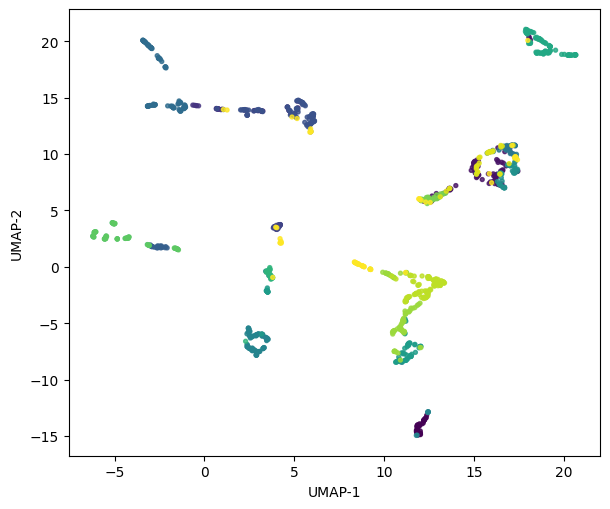

Saved: results/umap_embeddings.png


'\nThis cell takes your high-dimensional protein embeddings, uses UMAP \n(a smarter, non-linear method) to squeeze them into 2D while keeping clusters of similar \nproteins close together, and plots them as a colorful scatterplot.\nEach dot = one protein sequence, colored by family.\nIf your encoder learned good features, proteins from the same family will appear \ngrouped together as clean clusters.\n'

In [7]:
# UMAP (non-linear) for nicer cluster visualization
# Why: UMAP often shows family clusters clearly if embeddings carry functional signal.

'''
PCA (from the last cell) is linear — it only stretches and rotates your data.
But biological data (like protein embeddings) often lives on curvy, complex shapes — 
not flat planes.

So UMAP (Uniform Manifold Approximation and Projection) is a non-linear method that can twist, 
bend, and unwrap that structure, producing cleaner, more natural clusters for visualization.
'''

import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
Zu = reducer.fit_transform(Z)

plt.figure(figsize=(6.2,5.2))
plt.scatter(Zu[:,0], Zu[:,1], c=Y, s=8, alpha=0.8)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig(ROOT / "results/umap_embeddings.png", dpi=160)
plt.show()
print("Saved: results/umap_embeddings.png")
'''
This cell takes your high-dimensional protein embeddings, uses UMAP 
(a smarter, non-linear method) to squeeze them into 2D while keeping clusters of similar 
proteins close together, and plots them as a colorful scatterplot.
Each dot = one protein sequence, colored by family.
If your encoder learned good features, proteins from the same family will appear 
grouped together as clean clusters.
'''


In [8]:
#Quantative cluster quality
# silhouette, Davies-Bouldin 
'''
The previous cells gave you pictures (PCA, UMAP) — nice to see clusters.
But now, this cell gives you numbers — to measure how well those clusters are 
separated and consistent.
These are called cluster quality metrics — they quantify how tight and 
distinct your groups are.

silhouette_score → measures how clearly points belong to one cluster vs. others (higher is better).
davies_bouldin_score → measures how much clusters overlap (lower is better).

why you use PCA data (Zp) instead of the raw embeddings (Z):
PCA gives a smoothed, lower-dimensional version of your data (2D here)
It’s less noisy and more stable for distance-based metrics.
'''
from sklearn.metrics import silhouette_score, davies_bouldin_score

# On PCA space (usually more stable than raw Z for metrics)
sil = silhouette_score(Zp, Y, metric="euclidean")
dbi = davies_bouldin_score(Zp, Y)

print(f"Silouette (higher is better, ~0.2-0.6 typical): {sil:.3f}")
print(f"Davies-Bouldin (lower is better, ~1.5-3 typical): {dbi:.3f}")

#why - gives you a headline number to report in README

Silouette (higher is better, ~0.2-0.6 typical): 0.128
Davies-Bouldin (lower is better, ~1.5-3 typical): 1096728.214


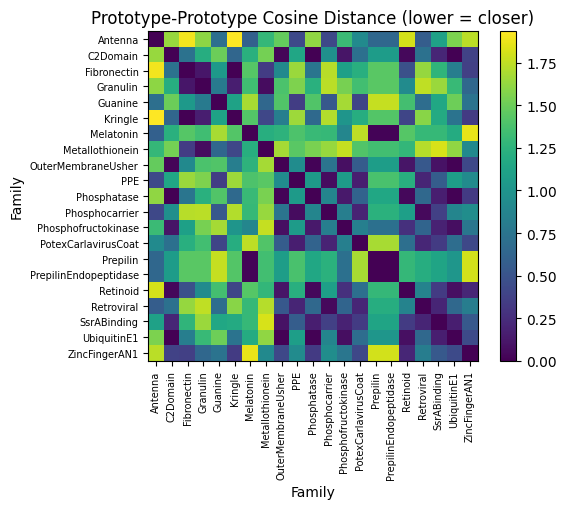

Saved: results/prototype_distance_heatmap.png


'\nThis cell builds one average embedding per protein family (a “prototype”), \nmeasures how similar each family’s prototype is to all the others using cosine distance, and then displays it as a colorful heatmap.\nDark = families with similar embeddings (possibly related functions).\nBright = distinct families.\nIt’s a quick way to see relationships between protein families in the learned embedding space.\n'

In [9]:
# Prototype distance heatmap
'''
Each protein family (e.g. kinase, transferase, etc.) has many sequences, 
and each sequence has an embedding (a numeric vector).
This cell:
Calculates one average embedding per family → called a prototype.
Measures cosine distance between every pair of prototypes → tells you how similar the families are.
Draws a heatmap (a colorful square grid) showing which families are close vs far in embedding space.
'''
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.protonet import compute_prototypes

#Compute mean embedding per family (prototype)
with torch.no_grad():
    D = Z.shape[1]
    fam_names = sorted(families.keys())
    P = []
    for name in fam_names:
        mask = np.array([n == name for n in NAMES])
        zfam = torch.tensor(Z[mask], dtype=torch.float32)
        P.append(zfam.mean(0, keepdim=True))
    P = torch.cat(P, dim=0)
    P = torch.nn.functional.normalize(P, p=2, dim=1)

#Cosine distance matrix
sim = (P @ P.T).clamp(-1,1).cpu().numpy()
dist = 1.0 - sim

plt.figure(figsize=(6.8,5.2))
im = plt.imshow(dist, cmap="viridis")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Prototype-Prototype Cosine Distance (lower = closer)")
plt.xlabel("Family")
plt.ylabel("Family")
plt.xticks(range(len(fam_names)), fam_names, rotation=90, fontsize=7)
plt.yticks(range(len(fam_names)), fam_names, fontsize=7)
plt.tight_layout()
plt.savefig(ROOT / "results/prototype_distance_heatmap.png", dpi=160)
plt.show()
print("Saved: results/prototype_distance_heatmap.png")
# Why: shows which families the model thinks are similar. Great for bio interpretation.
'''
This cell builds one average embedding per protein family (a “prototype”), 
measures how similar each family’s prototype is to all the others using cosine distance, and then displays it as a colorful heatmap.
Dark = families with similar embeddings (possibly related functions).
Bright = distinct families.
It’s a quick way to see relationships between protein families in the learned embedding space.
'''


In [10]:
# Nearest Neighbor families (prototype-level)
import numpy as np
'''
takes your prototype distance matrix (from the previous heatmap) 
and tells you, for each protein family, which other families are closest in embedding space.

This cell takes the distance matrix between family prototypes and lists, 
for each protein family, the 3 most similar other families based on embedding distance.
It prints a clean summary showing which families cluster closely in your 
learned embedding space.
'''
def nn_table(dist_matrix, names, k=3):
    """For each family, list k nearest other families by distance"""
    out = []
    for i, name in enumerate(names):
        idxs = np.argsort(dist_matrix[i])
        idxs = [j for j in idxs if j != i][:k] # skip self
        neighbors = [(names[j], float(dist_matrix[i,j])) for j in idxs]
        out.append((name, neighbors))
    return out

table = nn_table(dist, fam_names, k=3)
for name, neigh in table:
    print(f"{name:>24} -> " + ", ".join([f"{n} (d={d:.3f})" for n,d in neigh]))

#Why: a readable list you can paste into README to discuss interesting pairs.


                 Antenna -> Phosphocarrier (d=0.418), PPE (d=0.428), Retroviral (d=0.574)
                C2Domain -> UbiquitinE1 (d=0.006), Phosphatase (d=0.006), OuterMembraneUsher (d=0.025)
             Fibronectin -> Kringle (d=0.004), Granulin (d=0.119), Metallothionein (d=0.343)
                Granulin -> Metallothionein (d=0.066), Fibronectin (d=0.119), Kringle (d=0.166)
                 Guanine -> PPE (d=0.354), PotexCarlavirusCoat (d=0.405), Phosphocarrier (d=0.536)
                 Kringle -> Fibronectin (d=0.004), Granulin (d=0.166), ZincFingerAN1 (d=0.339)
               Melatonin -> PrepilinEndopeptidase (d=0.017), Prepilin (d=0.017), Antenna (d=0.593)
         Metallothionein -> Granulin (d=0.066), Fibronectin (d=0.343), Kringle (d=0.414)
      OuterMembraneUsher -> UbiquitinE1 (d=0.011), Phosphatase (d=0.016), C2Domain (d=0.025)
                     PPE -> Phosphocarrier (d=0.063), PotexCarlavirusCoat (d=0.160), Retroviral (d=0.200)
             Phosphatase -> C2Domain 

In [11]:
# CELL 10 — Save a Day 4 results snippet
readme = f"""# Day 4 – Embedding Visualization & Cluster Analysis

Artifacts:
- `results/pca_embeddings.png` – PCA scatter of all protein embeddings
- `results/umap_embeddings.png` – UMAP (cosine) scatter of embeddings
- `results/prototype_distance_heatmap.png` – cosine distance between family prototypes

Headline metrics (PCA space):
- Silhouette (higher is better): (see notebook cell)
- Davies–Bouldin (lower is better): (see notebook cell)

Notes:
- Embeddings are L2-normalized by the encoder; cosine distance is meaningful.
- Families that cluster together may share domains/functions → candidates for biological discussion.
- See Day 5 for ablations and hard-negative checks.

"""
with open(ROOT / "results/README_day4.md", "w") as f:
    f.write(readme)
print("Wrote: results/README_day4.md")

Wrote: results/README_day4.md
